# Transit Over Point Target
## 0. Imports

In [1]:
import sys
sys.path.append("../")

from surface import *
from source import *
from model import *

import numpy as np
from time import time as Time

## 1. Define surface

In [2]:
# surface
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

## 2. Create sources along a transit

In [3]:
# source
ss = []
n = 200
for x in np.linspace(0, 10000, n):
    source = Source(1e-9, 0.5e-6, (x, 5050, 25000))
    source.chirp(9e6, 1e6)
    ss.append(source)

## 3. Create models and simulate for each source location

In [7]:
ms = []
st = Time()
for i, s in enumerate(ss):
    print(f"Simulating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    model = Model(surf, s, reflect=False)
    #model.set_target((5050, 5050, -200))    # set target location
    model.set_target((5900, 5050, -200))
    model.gen_raypaths()    # generate raypaths
    model.comp_dopplers()
    model.gen_timeseries(show=False)    # simulate
    ms.append(model)
print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating: 200/200 (100.0%)     

Total processing time: 5 minutes and 0.3 seconds


## 4. Combine into radargram

In [18]:
st = 166.8e-6   # start
en = 175e-6  # end
dt = 1 / (8 * ss[0].f0)
N = int((en-st)/(dt))      # how many "range bins?"
print(f"{N} range bins with dt: {dt*1e6:1.6f} us")

# fast time dimension
ft = np.linspace(st, en, N)

# output radargram
rdrgrm = np.zeros((N, n)).astype(np.complex128)

# iterate through models and add to output radargram
for i, m in enumerate(ms):
    real = np.interp(ft, m.ts, np.real(m.signal))
    imag = np.interp(ft, m.ts, np.imag(m.signal))
    rdrgrm[:, i] = real + 1j * imag

590 range bins with dt: 0.013889 us


In [7]:
np.save("rdrgrm.npy", rdrgrm)

## 5. Show output

In [8]:
rdrgrm = np.load("../rdrgrm.npy")

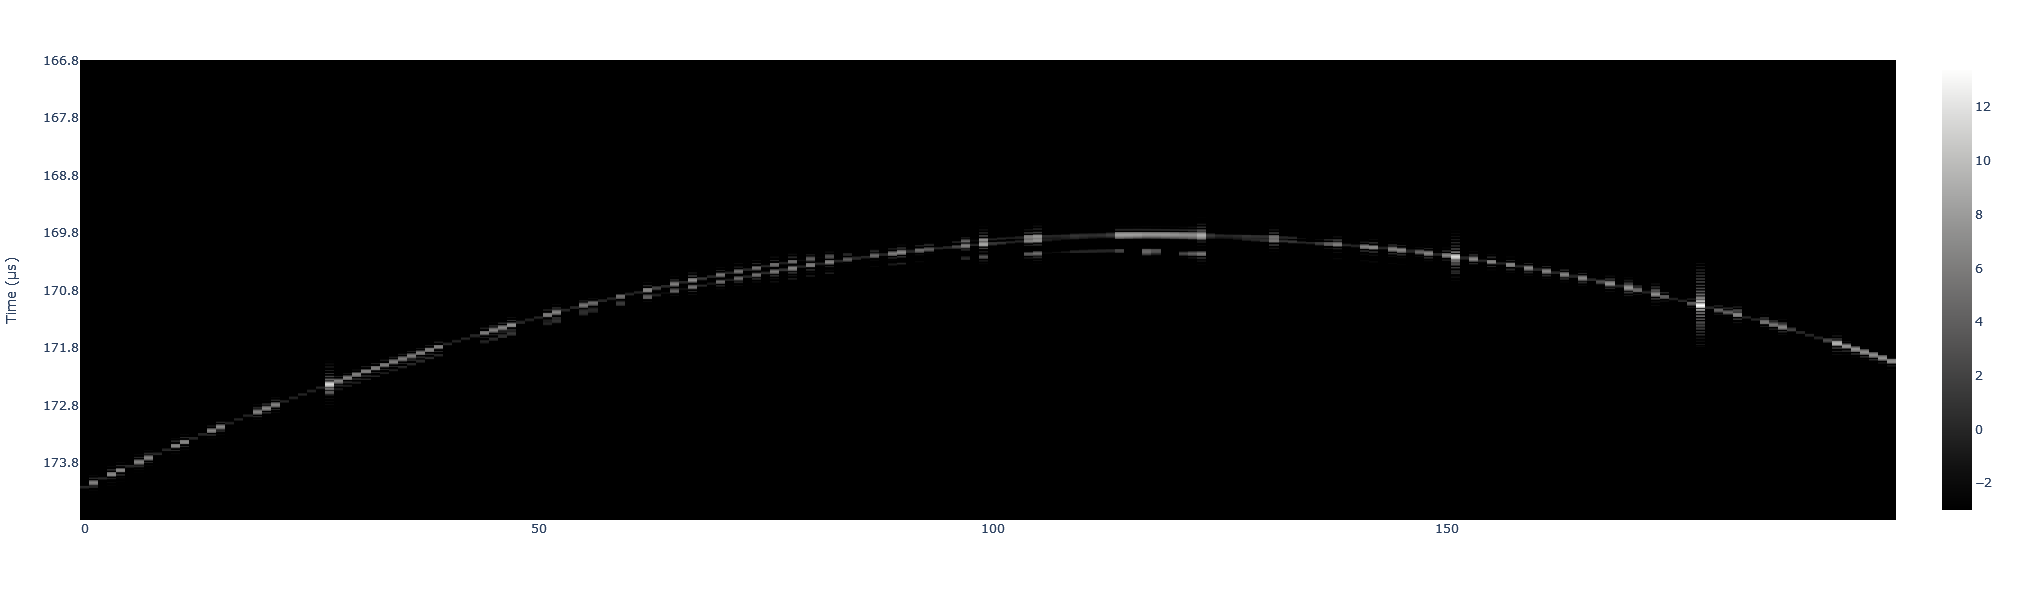

In [23]:
import plotly.express as px

st = 166.8e-6   # start
en = 175e-6  # end
dt = 1 / (8 * ss[0].f0)
N = int((en-st)/(dt))      # how many "range bins?"

fig = px.imshow(10*np.log10(np.abs(rdrgrm+1e-5)), aspect="auto", color_continuous_scale='gray', width=800, height=600, zmin=-3)
ticktext = ['{0:5.1f}'.format(val) for val in np.arange(st*1e6, en*1e6, 1)]
tickvals = np.linspace(0, N, len(ticktext))

fig.update_yaxes(
    tickvals=tickvals,
    ticktext=ticktext,
    title_text="Time (µs)"
)
fig.show()

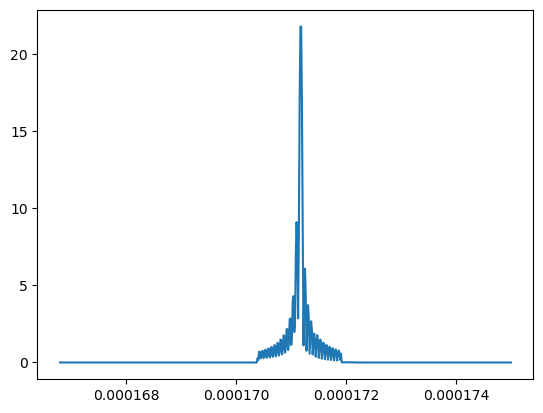

In [12]:
trace = rdrgrm[:,178]
plt.plot(np.linspace(st, en, N), np.abs(trace))
plt.show()

In [15]:
ss[178].z

25000